In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("HDFS_parsed.csv")

df["Date"] = df["Date"].astype(str).str.zfill(6)
df["Time"] = df["Time"].astype(str).str.zfill(6)
df["Datetime"] = pd.to_datetime(df["Date"] + df["Time"], format="%y%m%d%H%M%S")

component_counts = df["Component"].value_counts()
rare_components = component_counts[component_counts < 5].index
df = df[~df["Component"].isin(rare_components)]

df = df.set_index("Datetime")
df.head()

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
Datetime,,,,,,,,,
2008-11-09 20:35:18,1,081109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,[*]Receiving block[*]src:[*]dest:[*]
2008-11-09 20:35:18,2,081109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,[*]BLOCK* NameSystem[*]allocateBlock:[*]
2008-11-09 20:35:19,3,081109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,[*]Receiving block[*]src:[*]dest:[*]
2008-11-09 20:35:19,4,081109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,[*]Receiving block[*]src:[*]dest:[*]
2008-11-09 20:35:19,5,081109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,E11,[*]PacketResponder[*]for block[*]terminating[*]


### Графики распределения логов во времени (по компонентам).

In [3]:
logs_per_5min = (
    df.groupby(["Level", "Component"])
      .resample("5min")
      .size()
      .reset_index(name="Count")
)
logs_per_5min = logs_per_5min.sort_values(["Level", "Component", "Datetime"])


logs_per_5min["Smoothed"] = (
    logs_per_5min.groupby(["Level", "Component"])["Count"]
    .transform(lambda x: x.rolling(3, min_periods=1).mean())
)


logs_per_5min["Smoothed"] = (
    logs_per_5min.groupby(["Level", "Component"])["Count"]
    .transform(lambda x: x.rolling(3, min_periods=1).mean())
)

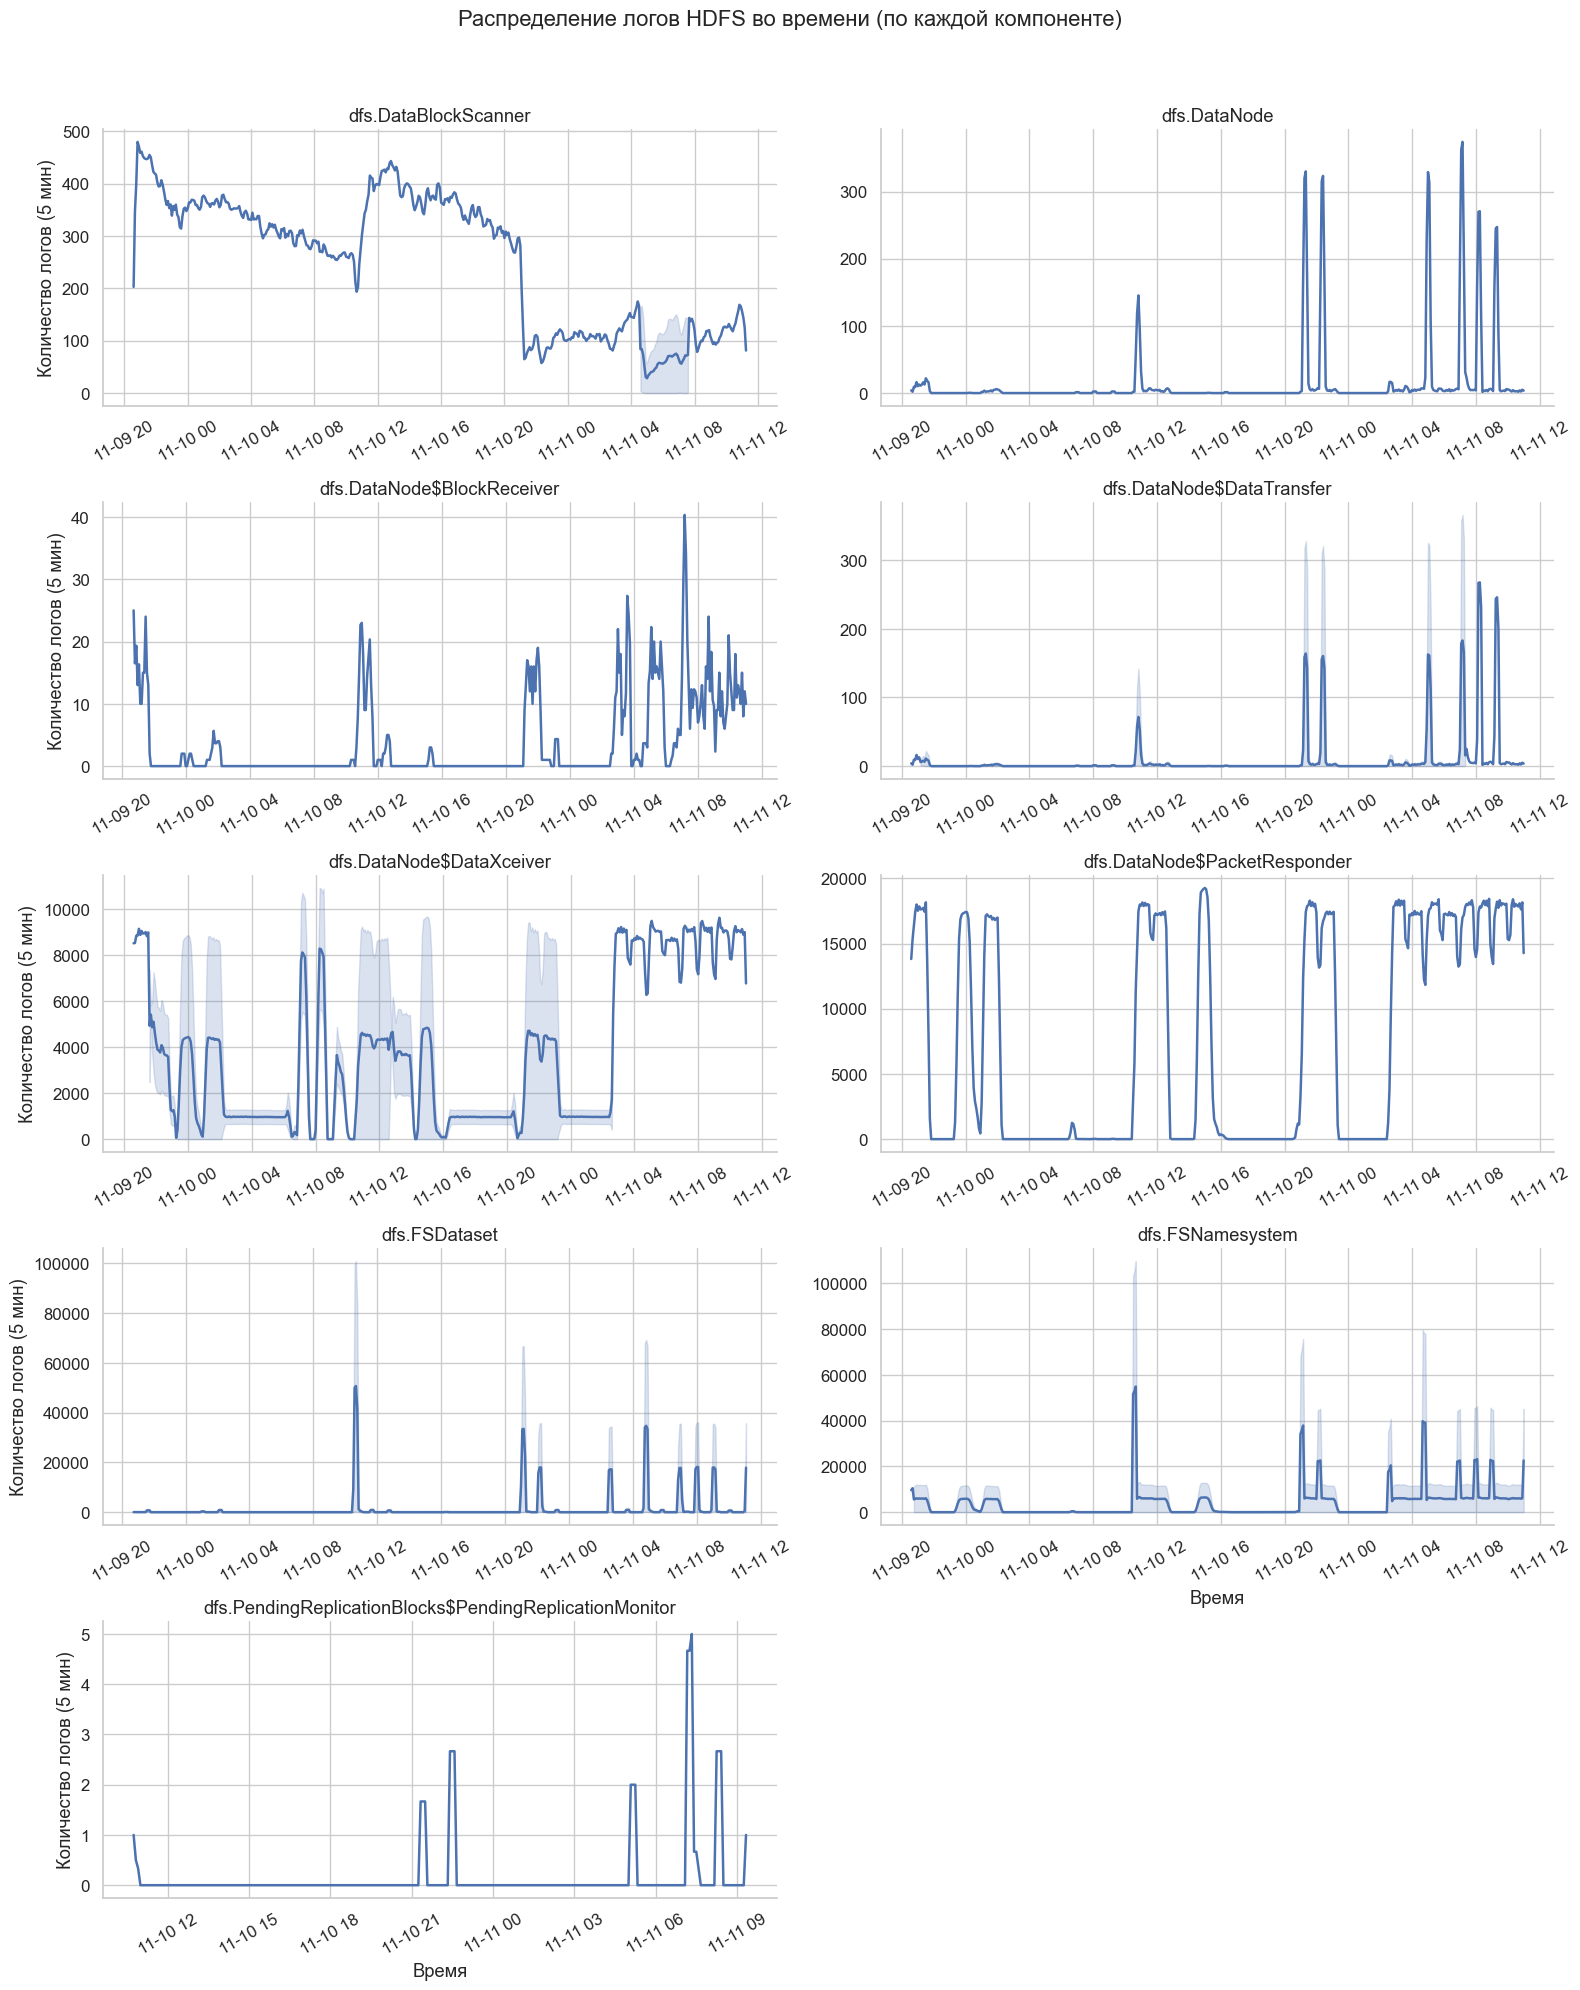

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=1.1)
g = sns.FacetGrid(logs_per_5min, col="Component", col_wrap=2, height=4, aspect=2, sharey=False, sharex=False)
g.map_dataframe(sns.lineplot, x="Datetime", y="Smoothed", linewidth=1.8)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Время", "Количество логов (5 мин)")
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(30)

plt.subplots_adjust(top=0.92, hspace=0.35)
g.figure.suptitle("Распределение логов HDFS во времени (по каждой компоненте)")
plt.show()

Для большинства компонентов наблюдаются чётко выраженные всплески, совпадающие по времени, что говорит о синхронной работе узлов при выполнении операций с данными.
Некоторые процессы, например `DataXceiver` и `PacketResponder`, демонстрируют регулярные колебания нагрузки, что указывает на цикличные операции передачи блоков.
Компоненты вроде `FSNamesystem` имеют более редкие, но масштабные пики, характерные для операций с метаданными и распределением блоков по кластеру.

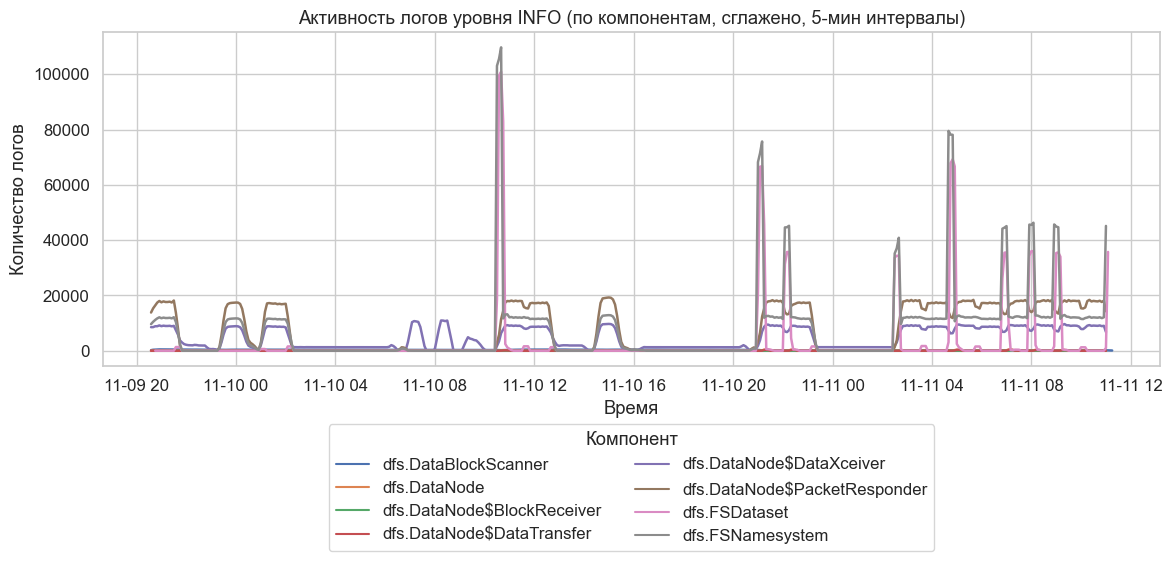

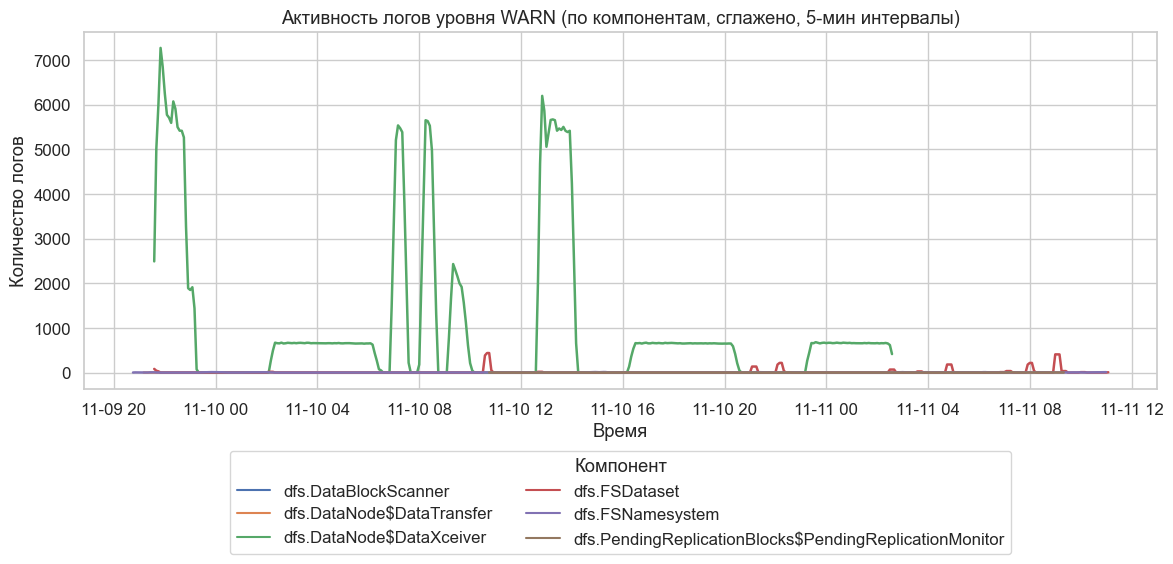

In [5]:
for level in logs_per_5min["Level"].unique():
    subset = logs_per_5min[logs_per_5min["Level"] == level]
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=subset, x="Datetime", y="Smoothed", hue="Component", linewidth=1.8)
    
    plt.subplots_adjust(left=0.25)
    plt.title(f"Активность логов уровня {level} (по компонентам, сглажено, 5-мин интервалы)")
    plt.xlabel("Время")
    plt.ylabel("Количество логов")
    plt.legend(title="Компонент", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.tight_layout()
    plt.show()

### Автокорреляция

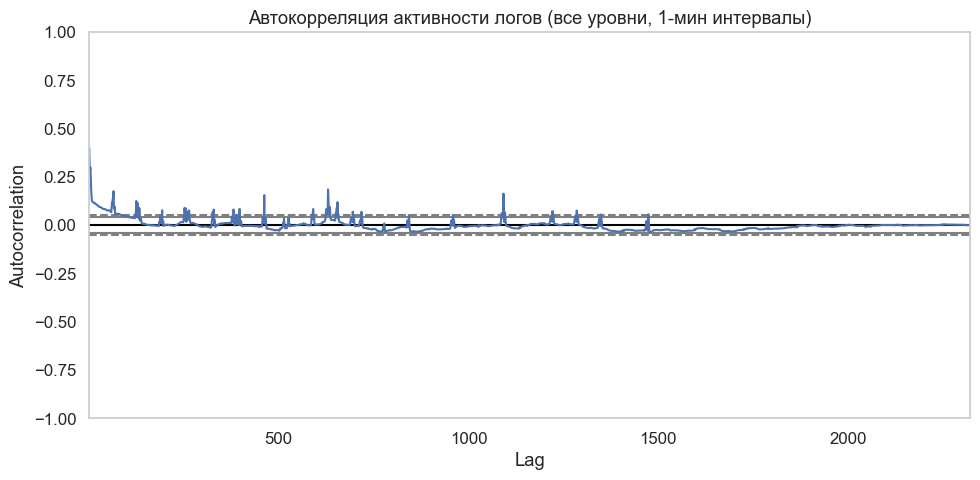

In [7]:
from pandas.plotting import autocorrelation_plot

logs_per_minute = df.resample("1min").size()

plt.figure(figsize=(10, 5))
autocorrelation_plot(logs_per_minute)
plt.title("Автокорреляция активности логов (все уровни, 1-мин интервалы)")
plt.tight_layout()
plt.show()

Автокорреляция активности логов показывает, что уровни активности HDFS имеют положительную зависимость на коротких лагах — периоды высокой активности обычно следуют друг за другом. Затем корреляция постепенно снижается, что указывает на волнообразный характер нагрузки.

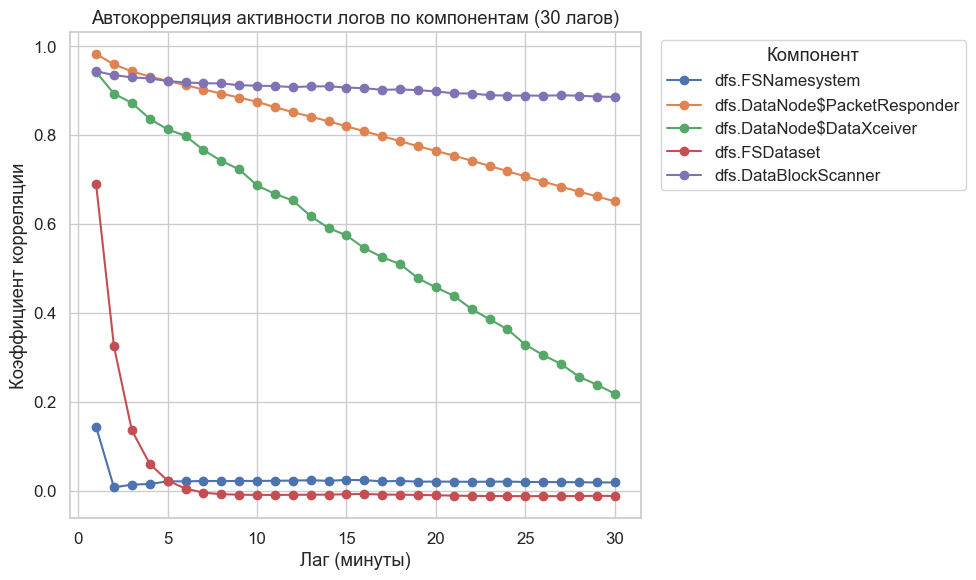

In [14]:
import numpy as np

def autocorr(x, lag):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1] if len(x) > lag else np.nan

plt.figure(figsize=(10, 6))
top_components = df["Component"].value_counts().head(5).index

for component in top_components:
    series = df[df["Component"] == component].resample("1min").size()
    autocorrs = [autocorr(series.values, lag) for lag in range(1, 31)]
    plt.plot(range(1, 31), autocorrs, marker="o", label=component)

plt.title("Автокорреляция активности логов по компонентам (30 лагов)")
plt.xlabel("Лаг (минуты)")
plt.ylabel("Коэффициент корреляции")
plt.legend(title="Компонент", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

Компоненты `DataNode$PacketResponder` и `DataBlockScanner` сохраняют высокую положительную корреляцию даже при больших лагах, что указывает на устойчивые и регулярные циклы активности этих процессов.
У других компонентов корреляция быстро снижается, что говорит о более случайном или нерегулярном характере их работы.

/var/folders/xb/nx2t3ss13xz9l0d9bf5jk9kh0000gn/T/ipykernel_55583/2081824153.py:7: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, acf_values, basefmt=" ", use_line_collection=True)


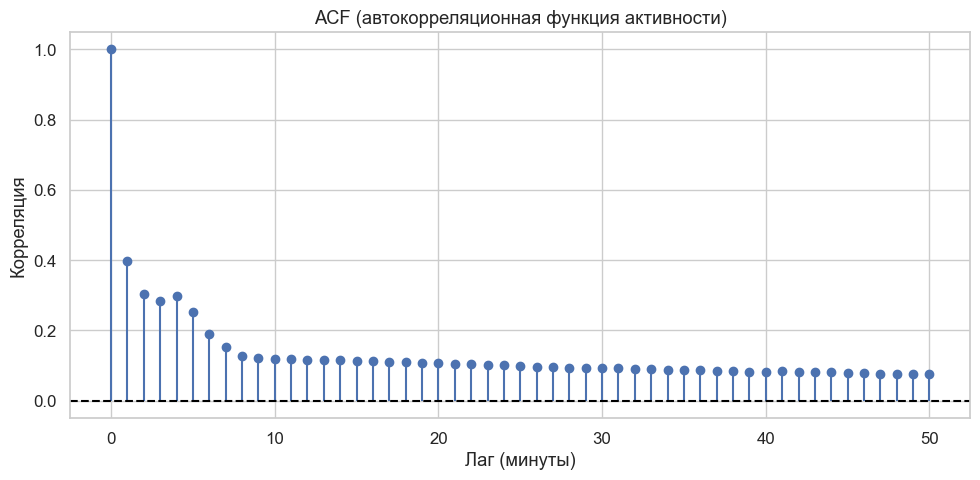

In [20]:
from statsmodels.tsa.stattools import acf

acf_values = acf(logs_per_minute, nlags=50, fft=True)
lags = np.arange(len(acf_values))

plt.figure(figsize=(10, 5))
plt.stem(lags, acf_values, basefmt=" ", use_line_collection=True)
plt.axhline(0, color="black", linestyle="--")
plt.title("ACF (автокорреляционная функция активности)")
plt.xlabel("Лаг (минуты)")
plt.ylabel("Корреляция")
plt.tight_layout()
plt.show()

График ACF показывает сильную положительную корреляцию на малых лагах, которая постепенно снижается по мере увеличения лага и стабилизируется около нуля.
Это указывает на то, что активность логов в HDFS имеет кратковременную зависимость во времени — всплески активности обычно сохраняются в течение нескольких минут, но затем теряют взаимосвязь.

### Всплески активности

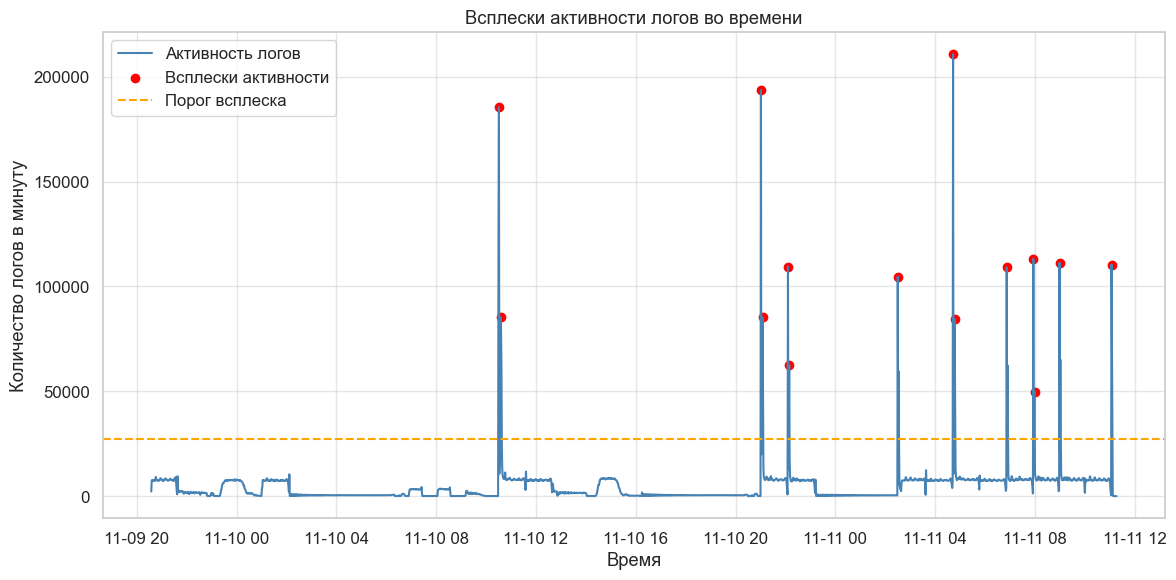

In [15]:
from scipy.signal import find_peaks

threshold = logs_per_minute.mean() + 2 * logs_per_minute.std()

peaks, _ = find_peaks(logs_per_minute, height=threshold, distance=3)

spike_times = logs_per_minute.index[peaks]
plt.figure(figsize=(12, 6))
plt.plot(logs_per_minute.index, logs_per_minute.values, label="Активность логов", color="steelblue")
plt.scatter(spike_times, logs_per_minute[peaks], color="red", label="Всплески активности")
plt.axhline(threshold, color="orange", linestyle="--", label="Порог всплеска")

plt.title("Всплески активности логов во времени")
plt.xlabel("Время")
plt.ylabel("Количество логов в минуту")
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

Красные точки обозначают аномальные всплески, соответствующие периодам интенсивной нагрузки на систему.
Большинство пиков кратковременны, что характерно для массовых операций записи или репликации блоков, однако наличие повторяющихся всплесков может указывать на временные перегрузки отдельных узлов кластера.

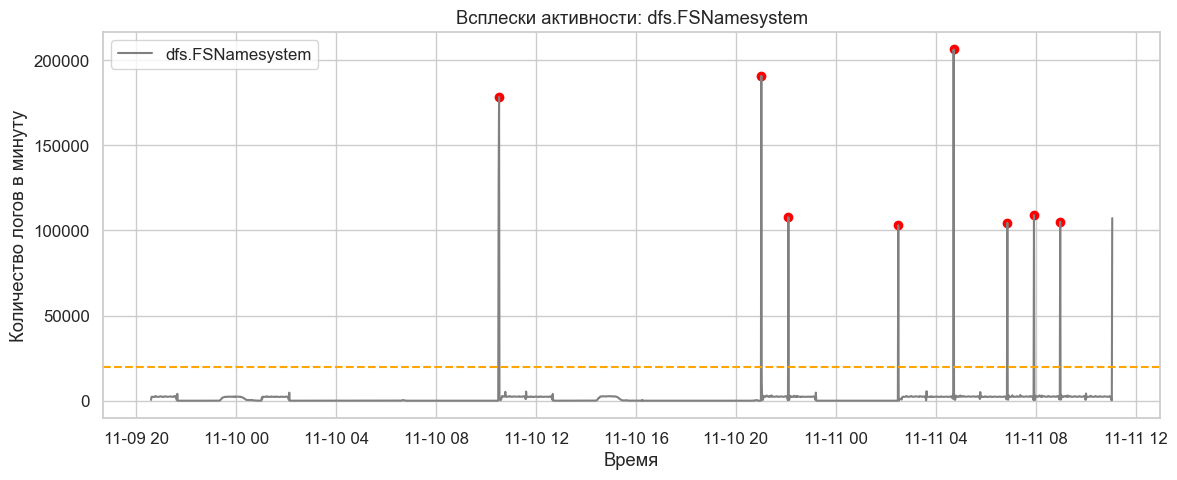

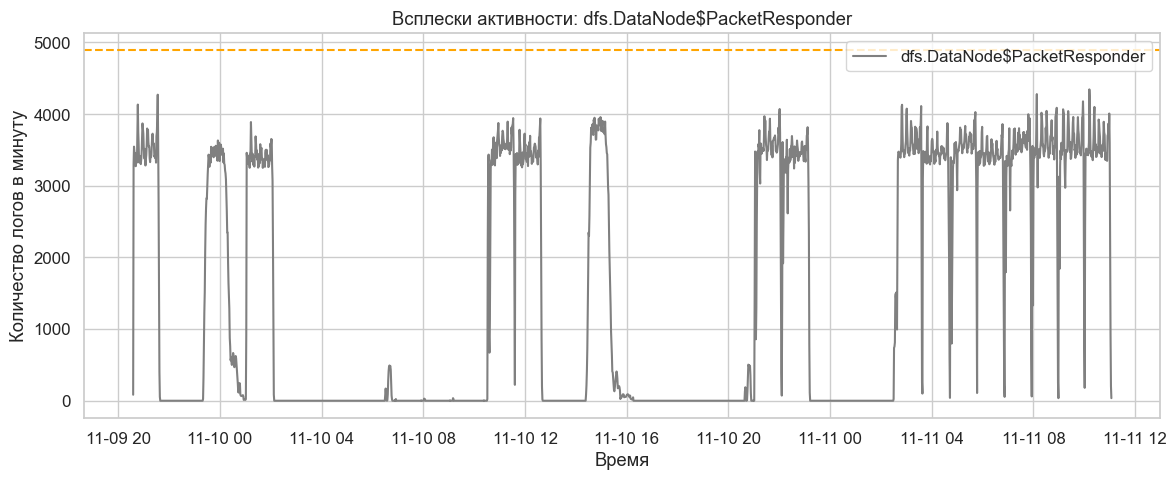

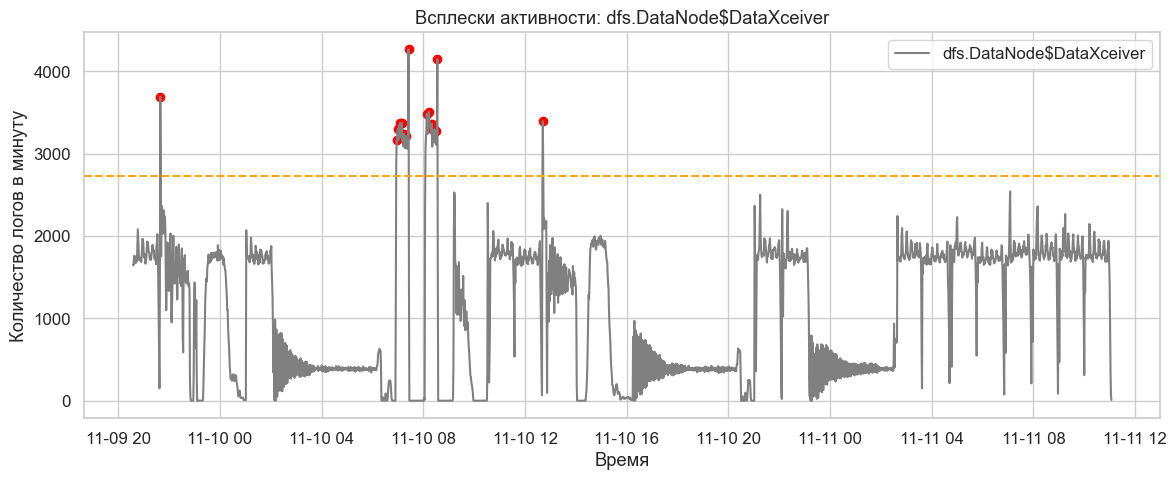

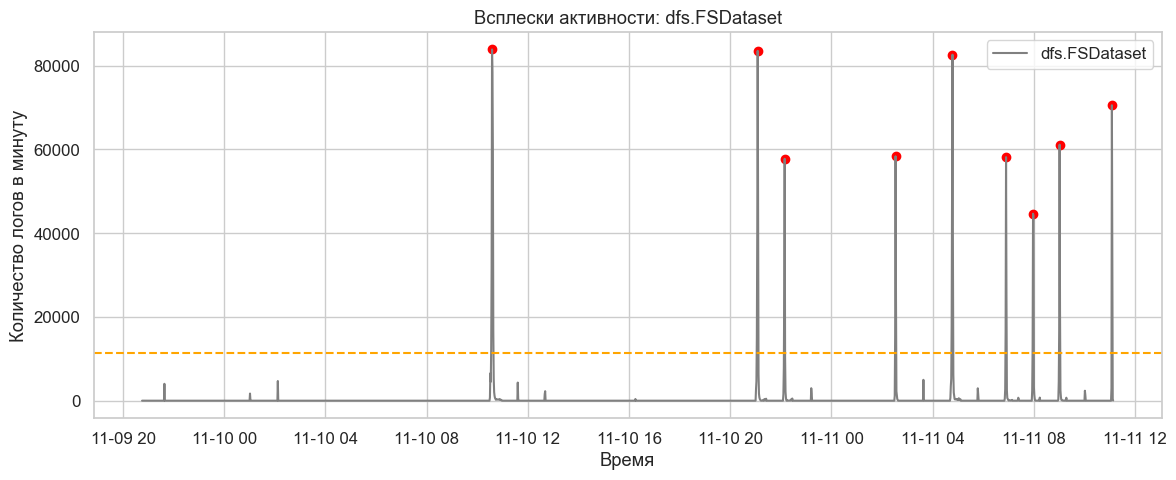

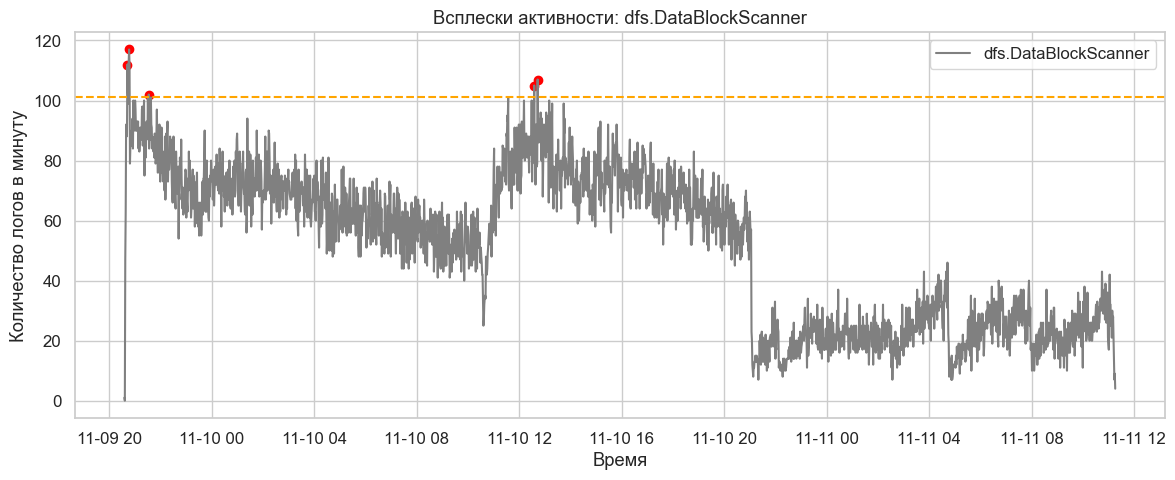

In [16]:
top_components = df["Component"].value_counts().head(5).index

for component in top_components:
    series = df[df["Component"] == component].resample("1min").size()
    threshold = series.mean() + 2 * series.std()
    peaks, _ = find_peaks(series, height=threshold, distance=3)

    plt.figure(figsize=(12, 5))
    plt.plot(series.index, series.values, label=f"{component}", color="gray")
    plt.scatter(series.index[peaks], series.values[peaks], color="red")
    plt.axhline(threshold, color="orange", linestyle="--")
    plt.title(f"Всплески активности: {component}")
    plt.xlabel("Время")
    plt.ylabel("Количество логов в минуту")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Всплески активности: 

**FSNamesystem:**
Редкие, но выраженные всплески соответствуют операциям с метаданными, например распределению или удалению блоков.
В отличие от DataNode-компонентов, активность FSNamesystem менее частая, но более “тяжёлая” по нагрузке, что объясняет повышение Latency в эти моменты.

**DataNode$PacketResponder:**
Компонента отвечает за подтверждение получения блоков.
Всплески на графике совпадают по времени с активностью DataXceiver, что подтверждает согласованную работу передачи и подтверждения блоков.

**DataNode$DataXceiver:**
Красные точки указывают на моменты, когда интенсивность передачи превышает нормальный уровень.
Регулярное появление таких всплесков говорит о циклической сетевой нагрузке, характерной для операций репликации или массового копирования данных.

**FSDataset:**
График показывает редкие, но очень выраженные пики активности компонента FSDataset, отвечающего за операции чтения и записи блоков на физические диски. Такие всплески возникают во время интенсивного ввода-вывода — например, при пакетной репликации или удалении блоков.

**DataBlockScanner:**
Активность изменяется волнообразно, с отдельными всплесками, превышающими порог. Этот компонент выполняет проверку целостности блоков, поэтому пики активности могут быть связаны с запуском плановых сканирований данных. Падения и последующие повышения уровня логов указывают на регулярное выполнение фоновый задач проверки блоков, что является нормальным поведением для HDFS.
